In [1]:
%config InlineBackend.figure_formats = ['svg']
from numpy.random import randint
import numpy as np # for importing numpy
import pandas as pd # for importing pandas
import matplotlib.pyplot as plt # for importing matplotlib
from matplotlib.patches import Polygon
from matplotlib.animation import FuncAnimation
import seaborn as sns # seaborn is used to plot
import time
%matplotlib inline
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, mean, when, lit, create_map, col, split, regexp_extract

In [2]:
# get the current time
prev = time.time()

In [3]:
# set matplotlib style to classic
plt.style.use('seaborn-v0_8-dark')

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)




In [5]:
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "8g").config("spark.executor.memory","8g").appName("Operations").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
train = spark.read.csv('../data/train.csv',inferSchema=True,header=True)
test = spark.read.csv('../data/test.csv',inferSchema=True,header=True)

In [7]:
def plot1dpie(ax,labels_values, labels, title, x,y):
	ax[y].pie(labels_values, labels = labels, autopct='%1.1f%%', shadow = True, startangle = 90)
	ax[y].title.set_text(title)

def plot2dpie(ax,labels_values, labels, title,x,y):
	# ca
	ax[x,y].pie(labels_values, labels = labels, autopct='%1.1f%%', shadow = True, startangle = 90)
	ax[x,y].title.set_text(title)


def plotpie(x,y,ax,labels_values, labels, title):
	# check if ax is 2d or 1d
	if len(ax.shape) == 1:
		plot1dpie(ax,labels_values, labels, title, x,y)
	else:
		plot2dpie(ax,labels_values, labels, title,x,y)

def multipie(data, titles, target_col, labels, array_cols, icols = -1, irows = -1):
	"""
	%%
	data in the form of 
	
	|Survived|1  |2 |3  |
	|1       |136|87|119|
	|1       |80 |97|372|
	
	titles = ['1 survival rate','2 survival rate','3 survival rate']
	target_col = 'Survived'
	labels = ['Survived','Died']
	array_cols = ['1','2','3']
	icols, irwos = 2,2
	"""
	input_cols = len(array_cols) + 1
	if icols == -1:
		ncols = 3
	else:
		ncols = icols
	if irows == -1:
		nrows = (input_cols - 1) // ncols  + 1
	else:
		nrows  = irows

	fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(8,2 * nrows))
	# first plot the sum of the target column
	labels_values = [0] * len(data)
	# get the sum of all the columns for each row and store it in a list
	# exclude the target_col column from the sums

	for i in range(len(data)):
		for j in range(len(array_cols)):
			column = array_cols[j]
			labels_values[i] += data.loc[i,column]


	plotpie(0,0,ax,labels_values, labels, title = 'Sum of ' + target_col)
	# now plot all the array_cols with the target_col individually
	for i in range(1, len(array_cols) + 1):
		labels_values = [0] * len(labels)
		for j in range(len(data)):
			labels_values[j] = data[array_cols[i-1]].iloc[j]
		row = (i) // ncols
		col = (i) % ncols
		plotpie(row,col,ax,labels_values, labels, title = titles[i-1])
	# delete unused plots axes
	for i in range(len(array_cols) + 1, ncols * nrows):
		row = i // ncols
		col = i % ncols
		fig.delaxes(ax[row,col])


	plt.tight_layout()

In [8]:
ssex = train.groupBy('Survived').pivot('sex').count().toPandas()

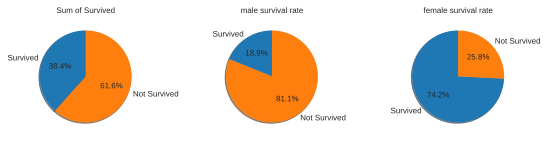

In [9]:
multipie(ssex, titles = ['male survival rate','female survival rate'], target_col = 'Survived', labels = ['Survived','Not Survived'],array_cols = ['male','female'])

apparently the females survived more than the males

In [10]:
ppclass = train.groupBy('Survived').pivot('Pclass').count().toPandas()
ppclass

,Survived,1,2,3
0,1,136,87,119
1,0,80,97,372


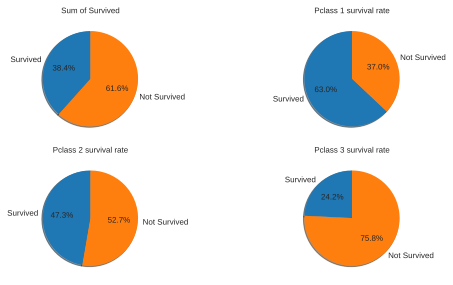

In [11]:
multipie(ppclass, titles = ['Pclass 1 survival rate','Pclass 2 survival rate','Pclass 3 survival rate'], target_col = 'Survived', labels = ['Survived','Not Survived'],array_cols = ['1','2','3'],irows = 2,icols = 2)

apparently the higher the class the higher the survival rate

In [12]:
embarked = train.groupBy('Survived').pivot('Embarked').count().toPandas()
embarked.fillna(0, inplace = True)
embarked

,Survived,null,C,Q,S
0,1,2.0,93,30,217
1,0,0.0,75,47,427


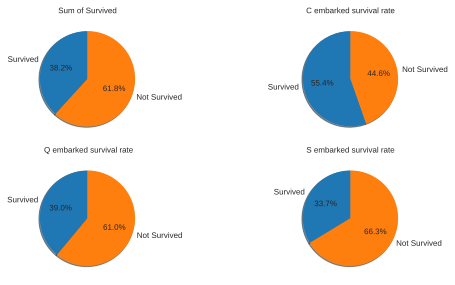

In [13]:
embarked.head()
multipie(embarked, titles = ['C embarked survival rate',' Q embarked survival rate','S embarked survival rate'], target_col = 'Survived',labels = ['Survived','Not Survived'],array_cols = ['C','Q','S'], icols = 2, irows = 2)

apparantly c embarked has a higher survival rate than the other two

In [14]:
# get a sample of 30% from the train pyspark dataframe
plot_sample = train.sample(False, 0.3, seed = 0).toPandas()

<AxesSubplot: xlabel='Survived', ylabel='Age'>

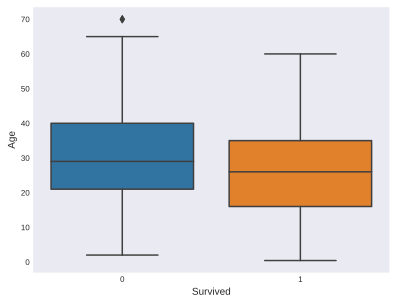

In [15]:
# now visualize the 'Age' column along the 'Survived' column
sns.boxplot(plot_sample, x = 'Survived', y = 'Age')

<AxesSubplot: xlabel='Age', ylabel='Fare'>

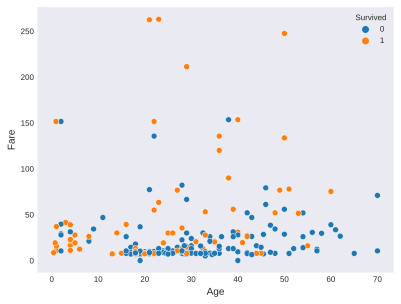

In [16]:
sns.scatterplot(plot_sample, x = 'Age', y = 'Fare', hue = 'Survived')

apparently the younger people had a higher likehood of survival, but since they were in the lower classes it summed for a lower survival rate
to test this hipothesis we will compare people with the same embarked, sex and pclass

=============
==== Data cleaning =====
=============

In [17]:
# check for all null values
for col in train.columns:
	print(col, train.filter(train[col].isNull()).count())

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


In [18]:
# age, cabin, and embarked columns have some missing data.

# not only does cabin have a lot of missing values, but it's highly related to ticket class since cabins were distributed according to these classes. we'll drop this column!

# for age and embarked, we will fill in missing values

In [19]:
train = train.fillna({"Embarked":"S"})

# for age imputation, we ough to take the title of the person in the name column and impute the average age for that specific group of people with such a title.
# Mrs, for instance, tends to be older than Miss

In [20]:
# counting the ages per title and getting the average age for each title
train = train.withColumn('Title', regexp_extract(train.Name, '([A-Za-z]+)\.',1))

In [21]:
title_avg = train.groupBy('Title').agg({'Age':'mean','Title':'count'})

In [22]:
title_avg.show()

+--------+------------+------------------+
|   Title|count(Title)|          avg(Age)|
+--------+------------+------------------+
|     Don|           1|              40.0|
|    Miss|         182|21.773972602739725|
|Countess|           1|              33.0|
|     Col|           2|              58.0|
|     Rev|           6|43.166666666666664|
|    Lady|           1|              48.0|
|  Master|          40| 4.574166666666667|
|     Mme|           1|              24.0|
|    Capt|           1|              70.0|
|      Mr|         517|32.368090452261306|
|      Dr|           7|              42.0|
|     Mrs|         125|35.898148148148145|
|     Sir|           1|              49.0|
|Jonkheer|           1|              38.0|
|    Mlle|           2|              24.0|
|   Major|           2|              48.5|
|      Ms|           1|              28.0|
+--------+------------+------------------+



In [23]:
def age_imputter(data, title, age):
	return data.withColumn('Age',when((data.Age.isNull()) & (data.Title == title), age).otherwise(data.Age))

In [24]:
# get all the rows that have the age as null
age_null = train.filter(train['Age'].isNull())

In [25]:
title_names = age_null.select('Title').distinct()

In [26]:
# now we have all the titles that have null values
title_names.show()

+------+
| Title|
+------+
|  Miss|
|Master|
|    Mr|
|    Dr|
|   Mrs|
+------+



In [27]:
# Register the DataFrame as a SQL temporary view
title_names.createOrReplaceTempView("title_names")
title_avg.createOrReplaceTempView("title_avg")

In [28]:
# will join the two tables
query = """
select title_names.Title, `count(Title)` as count, `avg(Age)` as avg_age
from title_names
inner join title_avg
on title_names.Title = title_avg.Title
"""

sql_results = spark.sql(query)

In [29]:
sql_results = sql_results.toPandas()

In [30]:
sql_results

,Title,count,avg_age
0,Miss,182,21.773973
1,Master,40,4.574167
2,Mr,517,32.368090
3,Dr,7,42.000000
4,Mrs,125,35.898148


In [31]:
for i in range(len(sql_results)):
	title = sql_results.loc[i,'Title']
	avg_age =sql_results.loc[i,'avg_age'] 
	avg_age = round(avg_age, 2)
	print(title,avg_age )
	train = age_imputter(train, title, avg_age)

Miss 21.77
Master 4.57
Mr 32.37
Dr 42.0
Mrs 35.9


In [32]:
# check for all null values
for col in train.columns:
	print(col, train.filter(train[col].isNull()).count())

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 0
Title 0


In [33]:
# we will remove all teh unnecessary columns
train = train.drop('PassengerId','Cabin','Name','Ticket','Title')

In [34]:
train.show()

+--------+------+------+-----+-----+-----+-------+--------+
|Survived|Pclass|   Sex|  Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+-----+-----+-----+-------+--------+
|       0|     3|  male| 22.0|    1|    0|   7.25|       S|
|       1|     1|female| 38.0|    1|    0|71.2833|       C|
|       1|     3|female| 26.0|    0|    0|  7.925|       S|
|       1|     1|female| 35.0|    1|    0|   53.1|       S|
|       0|     3|  male| 35.0|    0|    0|   8.05|       S|
|       0|     3|  male|32.37|    0|    0| 8.4583|       Q|
|       0|     1|  male| 54.0|    0|    0|51.8625|       S|
|       0|     3|  male|  2.0|    3|    1| 21.075|       S|
|       1|     3|female| 27.0|    0|    2|11.1333|       S|
|       1|     2|female| 14.0|    1|    0|30.0708|       C|
|       1|     3|female|  4.0|    1|    1|   16.7|       S|
|       1|     1|female| 58.0|    0|    0|  26.55|       S|
|       0|     3|  male| 20.0|    0|    0|   8.05|       S|
|       0|     3|  male| 39.0|    1|    

=============
==== Creating a Machine Learning Model =====
=============

In [35]:
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [36]:
# converting sex and embarked columns to numeric index
indexer = StringIndexer(inputCols = ['Sex','Embarked'],outputCols = ['SexIndex','EmbarkedIndex'])
indexer_model = indexer.fit(train)

In [37]:
train1 = indexer_model.transform(train)

In [38]:
train1 = train1.drop('Sex','Embarked')



In [39]:
# separating variables into independent and dependent variables with VectorAssembler
assembler = VectorAssembler(inputCols = train1.columns[1:], outputCol = 'features')
train1 = assembler.transform(train1).select('features','Survived')

In [40]:
train1.limit(10).toPandas()

,features,Survived
0,"[3.0, 22.0, 1.0, 0.0, 7.25, 0.0, 0.0]",0
1,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 1.0]",1
2,"[3.0, 26.0, 0.0, 0.0, 7.925, 1.0, 0.0]",1
3,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0, 0.0]",1
4,"(3.0, 35.0, 0.0, 0.0, 8.05, 0.0, 0.0)",0
5,"[3.0, 32.37, 0.0, 0.0, 8.4583, 0.0, 2.0]",0
6,"(1.0, 54.0, 0.0, 0.0, 51.8625, 0.0, 0.0)",0
7,"[3.0, 2.0, 3.0, 1.0, 21.075, 0.0, 0.0]",0
8,"[3.0, 27.0, 0.0, 2.0, 11.1333, 1.0, 0.0]",1
9,"[2.0, 14.0, 1.0, 0.0, 30.0708, 1.0, 1.0]",1


In [41]:
# generate a random seed taken from the current time
import time

In [42]:
from tqdm import tqdm

In [43]:

lr_best = 0
rf_best = 0
gbt_best = 0

lr_scores = []
rf_scores = []
gbt_scores = []


accuracy = MulticlassClassificationEvaluator(labelCol = 'Survived',metricName = 'accuracy')

for i in range(100):
	seed = int((time.time() - int(time.time()))*10000)
	train_ds, valid_ds = train1.randomSplit([0.7,0.3],seed = seed)
	lr_test = LogisticRegression(labelCol = 'Survived')
	model = lr_test.fit(train_ds)
	prediction = model.transform(valid_ds)
	lr_pred = accuracy.evaluate(prediction)

	if lr_pred >= lr_best:
		lr_best = lr_pred
		lr = lr_test

	rf_test = RandomForestClassifier(labelCol='Survived')
	model = rf_test.fit(train_ds)
	prediction = model.transform(valid_ds)
	rf_pred = accuracy.evaluate(prediction)

	if rf_pred >= rf_best:
		rf_best = rf_pred
		rf = rf_test

	gbt_test = GBTClassifier(labelCol='Survived')
	model = gbt_test.fit(train_ds)
	predictions = model.transform(valid_ds)
	gbt_pred = accuracy.evaluate(predictions)

	if gbt_pred >= gbt_best:
		gbt_best = gbt_pred
		gbt = gbt_test

	lr_scores.append(lr_pred)
	rf_scores.append(rf_pred)
	gbt_scores.append(gbt_pred)

In [44]:
# use a boxplot to compare all the models
model_scores = pd.DataFrame({'Logistic Regression':lr_scores,'Random Forest':rf_scores,'Gradient Boosted Trees':gbt_scores})

<AxesSubplot: >

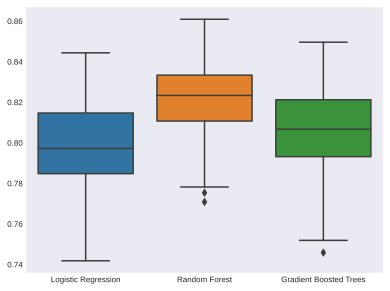

In [45]:
sns.boxplot(data = model_scores)

In [46]:
# after 100 runs apparently random forest is better
# lets do a ttest to see if the difference is significant!
from scipy.stats import ttest_rel

In [47]:
for col in model_scores.columns:
	for col2 in model_scores.columns:
		if col != col2:
			ttest = ttest_rel(model_scores[col],model_scores[col2])
			print(col,col2)
			print(ttest)

# pvalue < 0.05 -> there is a significant difference

Logistic Regression Random Forest
TtestResult(statistic=-14.415893176001996, pvalue=4.66596846429023e-26, df=99)
Logistic Regression Gradient Boosted Trees
TtestResult(statistic=-3.678737818811392, pvalue=0.0003813514035622246, df=99)
Random Forest Logistic Regression
TtestResult(statistic=14.415893176001996, pvalue=4.66596846429023e-26, df=99)
Random Forest Gradient Boosted Trees
TtestResult(statistic=8.674100804245608, pvalue=8.452926935102856e-14, df=99)
Gradient Boosted Trees Logistic Regression
TtestResult(statistic=3.678737818811392, pvalue=0.0003813514035622246, df=99)
Gradient Boosted Trees Random Forest
TtestResult(statistic=-8.674100804245608, pvalue=8.452926935102856e-14, df=99)


 now that we have seen that the difference is PRETTY significant now we are sure that
 random forest is the best model for this dataset

In [48]:
# check for all null values
for col in test.columns:
	print(col, test.filter(test[col].isNull()).count())

PassengerId 0
Pclass 0
Name 0
Sex 0
Age 86
SibSp 0
Parch 0
Ticket 0
Fare 1
Cabin 327
Embarked 0


In [49]:
# age, cabin, and embarked columns have some missing data.

# not only does cabin have a lot of missing values, but it's highly related to ticket class since cabins were distributed according to these classes. we'll drop this column!

# for age and embarked, we will fill in missing values

In [50]:
test = test.fillna({"Embarked":"S"})

test = test.fillna({'Fare':14.45})

# for age imputation, we ough to take the title of the person in the name column and impute the average age for that specific group of people with such a title.
# Mrs, for instance, tends to be older than Miss

In [51]:
# counting the ages per title and getting the average age for each title
test = test.withColumn('Title', regexp_extract(test.Name, '([A-Za-z]+)\.',1))

In [52]:
title_avg.show()

+--------+------------+------------------+
|   Title|count(Title)|          avg(Age)|
+--------+------------+------------------+
|     Don|           1|              40.0|
|    Miss|         182|21.773972602739725|
|Countess|           1|              33.0|
|     Col|           2|              58.0|
|     Rev|           6|43.166666666666664|
|    Lady|           1|              48.0|
|  Master|          40| 4.574166666666667|
|     Mme|           1|              24.0|
|    Capt|           1|              70.0|
|      Mr|         517|32.368090452261306|
|      Dr|           7|              42.0|
|     Mrs|         125|35.898148148148145|
|     Sir|           1|              49.0|
|Jonkheer|           1|              38.0|
|    Mlle|           2|              24.0|
|   Major|           2|              48.5|
|      Ms|           1|              28.0|
+--------+------------+------------------+



In [53]:
# get all the rows that have the age as null
age_null = test.filter(test['Age'].isNull())

In [54]:
title_names = age_null.select('Title').distinct()

In [55]:
# now we have all the titles that have null values
title_names.show()

+------+
| Title|
+------+
|  Miss|
|Master|
|    Mr|
|   Mrs|
|    Ms|
+------+



In [56]:
# Register the DataFrame as a SQL temporary view
title_names.createOrReplaceTempView("title_names")
title_avg.createOrReplaceTempView("title_avg")

In [57]:
# will join the two tables
query = """
select title_names.Title, `count(Title)` as count, `avg(Age)` as avg_age
from title_names
inner join title_avg
on title_names.Title = title_avg.Title
"""

sql_results = spark.sql(query)

In [58]:
sql_results = sql_results.toPandas()

In [59]:
sql_results

,Title,count,avg_age
0,Miss,182,21.773973
1,Master,40,4.574167
2,Mr,517,32.368090
3,Mrs,125,35.898148
4,Ms,1,28.000000


In [60]:
for i in range(len(sql_results)):
	title = sql_results.loc[i,'Title']
	avg_age =sql_results.loc[i,'avg_age'] 
	avg_age = round(avg_age, 2)
	print(title,avg_age )
	test = age_imputter(test, title, avg_age)

Miss 21.77
Master 4.57
Mr 32.37
Mrs 35.9
Ms 28.0


In [61]:
# check for all null values
for col in test.columns:
	print(col, test.filter(test[col].isNull()).count())

PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 327
Embarked 0
Title 0


In [62]:
# we will remove all teh unnecessary columns
test = test.drop('Cabin','Name','Ticket','Title')

In [63]:
test.limit(10).toPandas()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
5,897,3,male,14.0,0,0,9.2250,S
6,898,3,female,30.0,0,0,7.6292,Q
7,899,2,male,26.0,1,1,29.0000,S
8,900,3,female,18.0,0,0,7.2292,C
9,901,3,male,21.0,2,0,24.1500,S


In [64]:
pipeline = Pipeline(stages = [indexer, assembler, rf])

In [65]:
print(rf)

RandomForestClassifier_c0e70987c0f8


In [66]:
params = ParamGridBuilder().\
		addGrid(rf.maxDepth, [3,4,5]).\
		addGrid(rf.numTrees, [50,500,1000]).\
		addGrid(rf.minInfoGain, [0.0,0.01, 0.1]).\
		addGrid(rf.minInstancesPerNode, [1,2,3]).\
		addGrid(rf.impurity, ["gini","entropy"]).\
		addGrid(rf.minInstancesPerNode, [1,5,10]).\
		addGrid(rf.maxBins, [20,32,50]).\
		build()

In [67]:
cv = CrossValidator(estimator = pipeline, estimatorParamMaps = params, evaluator = accuracy, numFolds = 5)

model_final = cv.fit(train)
pred_train = model_final.transform(train)
accuracy.evaluate(pred_train)

23/02/01 08:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1482.5 KiB
23/02/01 08:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB
23/02/01 08:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1488.7 KiB
23/02/01 08:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1467.2 KiB
23/02/01 08:11:34 WARN DAGScheduler: Broadcasting large task binary with size 1463.2 KiB
23/02/01 08:11:35 WARN DAGScheduler: Broadcasting large task binary with size 1461.3 KiB
23/02/01 08:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1463.3 KiB
23/02/01 08:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1462.7 KiB
23/02/01 08:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1458.5 KiB
23/02/01 08:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1444.5 KiB
23/02/01 08:11:39 WARN DAGScheduler: Broadcasting large task binary with size 1447.4 KiB
23/02/01 08:11:39 WAR

23/02/01 08:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1038.2 KiB
23/02/01 08:12:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB
23/02/01 08:12:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:12:35 WARN DAGScheduler: Broadcasting large task binary with size 1040.3 KiB
23/02/01 08:12:35 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:12:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:12:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:12:39 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
23/02/01 08:12:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:12:41 WARN DAGScheduler: Broad

23/02/01 08:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1027.7 KiB
23/02/01 08:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1666.7 KiB
23/02/01 08:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1562.0 KiB
23/02/01 08:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1570.7 KiB
23/02/01 08:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1572.7 KiB
23/02/01 08:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1021.7 KiB
23/02/01 08:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1601.9 KiB
23/02/01 08:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1021.6 KiB
23/02/01 08:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1604.5 KiB
23/02/01 08:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
23/02/01 08:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1621.8 KiB
23/02/01 08:13:57 WAR

23/02/01 08:14:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1040.6 KiB
23/02/01 08:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1995.6 KiB
23/02/01 08:14:49 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1662.2 KiB
23/02/01 08:14:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/02/01 08:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1692.7 KiB
23/02/01 08:14:52 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:14:53 WARN DAGScheduler: Broadcasting large task binary with size 1704.1 KiB
23/02/01 08:14:53 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:14:54 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
23/02/01 08:14:54 WARN DAGScheduler:

23/02/01 08:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1079.0 KiB
23/02/01 08:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1834.4 KiB
23/02/01 08:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1870.1 KiB
23/02/01 08:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.1 KiB
23/02/01 08:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1810.8 KiB
23/02/01 08:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1830.9 KiB
23/02/01 08:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1072.8 KiB
23/02/01 08:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1802.9 KiB
23/02/01 08:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1847.1 KiB
23/02/01 08:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1060.0 KiB
23/02/01 08:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1782.1 KiB
23/02/01 08:16:07 WAR

23/02/01 08:16:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/02/01 08:16:52 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/02/01 08:16:52 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
23/02/01 08:16:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:16:53 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/02/01 08:16:54 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/02/01 08:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1054.5 KiB
23/02/01 08:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/02/01 08:16:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/02/01 08:16:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/02/01 08:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1053.8 KiB
23/02/01 08:16:58 WARN DAGScheduler: Broadcas

23/02/01 08:17:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/02/01 08:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1620.8 KiB
23/02/01 08:17:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:17:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1640.3 KiB
23/02/01 08:17:55 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:17:56 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1644.1 KiB
23/02/01 08:17:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:17:58 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB
23/02/01 08:17:59 WARN DAGScheduler: Broad

23/02/01 08:19:13 WARN DAGScheduler: Broadcasting large task binary with size 1052.9 KiB
23/02/01 08:19:13 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:19:14 WARN DAGScheduler: Broadcasting large task binary with size 1052.2 KiB
23/02/01 08:19:14 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1051.6 KiB
23/02/01 08:19:16 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1050.1 KiB
23/02/01 08:19:17 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1050.7 KiB
23/02/01 08:19:18 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:19:19 WARN DAGScheduler: Broadcasting large task binary with size 1049.0 KiB
23/02/01 08:19:19 WARN DAGScheduler:

23/02/01 08:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1086.0 KiB
23/02/01 08:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1802.5 KiB
23/02/01 08:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
23/02/01 08:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1731.5 KiB
23/02/01 08:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1066.7 KiB
23/02/01 08:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1735.3 KiB
23/02/01 08:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1063.2 KiB
23/02/01 08:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1747.8 KiB
23/02/01 08:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1094.6 KiB
23/02/01 08:20:33 WARN DAGScheduler: Broadcasting large task binary with size 1709.6 KiB
23/02/01 08:20:33 WARN DAGScheduler: Broadcasting large task binary with size 1089.9 KiB
23/02/01 08:20:34 WAR

23/02/01 08:21:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:21:21 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
23/02/01 08:21:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:21:22 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
23/02/01 08:21:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:21:24 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1053.1 KiB
23/02/01 08:21:25 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:21:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:21:26 WARN DAGScheduler: Broadcas

23/02/01 08:22:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:22:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:22:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:22:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:22:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:22:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:22:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:22:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:22:21 WARN DAGScheduler: Broadcasting larg

23/02/01 08:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1916.7 KiB
23/02/01 08:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1035.7 KiB
23/02/01 08:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1708.7 KiB
23/02/01 08:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1913.9 KiB
23/02/01 08:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
23/02/01 08:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1700.9 KiB
23/02/01 08:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1927.0 KiB
23/02/01 08:23:24 WARN DAGScheduler: Broadcasting large task binary with size 1236.7 KiB
23/02/01 08:23:25 WARN DAGScheduler: Broadcasting large task binary with size 1710.4 KiB
23/02/01 08:23:25 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
23/02/01 08:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1723.5 KiB
23/02/01 08:23:27 WAR

23/02/01 08:23:53 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/02/01 08:23:54 WARN DAGScheduler: Broadcasting large task binary with size 1048.8 KiB
23/02/01 08:23:54 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:23:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/02/01 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/02/01 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
23/02/01 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:23:58 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/02/01 08:23:58 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/02/01 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
23/02/01 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:24:00 WARN DAGScheduler: Broadcas

23/02/01 08:24:50 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:24:50 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/02/01 08:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
23/02/01 08:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1984.3 KiB
23/02/01 08:24:52 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:24:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/02/01 08:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
23/02/01 08:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1689.7 KiB
23/02/01 08:24:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:24:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1009.4 KiB
23/02/01 08:24:56 WARN DAGScheduler: Br

23/02/01 08:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1196.6 KiB
23/02/01 08:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1197.7 KiB
23/02/01 08:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
23/02/01 08:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
23/02/01 08:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
23/02/01 08:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1196.1 KiB
23/02/01 08:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1195.9 KiB
23/02/01 08:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1197.0 KiB
23/02/01 08:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
23/02/01 08:26:15 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1056.8 KiB
23/02/01 08:26:16 WARN D

23/02/01 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:27:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:27:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1092.7 KiB
23/02/01 08:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1800.3 KiB
23/02/01 08:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1093.1 KiB
23/02/01 08:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1816.9 KiB
23/02/01 08:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1092.1 KiB
23/02/01 08:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1812.2 KiB
23/02/01 08:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.4 KiB
23/02/01 08:27:33 WARN DAGSchedul

23/02/01 08:28:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/02/01 08:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1049.0 KiB
23/02/01 08:28:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:28:22 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1050.1 KiB
23/02/01 08:28:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:28:23 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1048.7 KiB
23/02/01 08:28:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:28:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/02/01 08:28:26 WARN DAGScheduler: Broadcasting large task binary with size 1056.8 KiB
23/02/01 08:28:26 WARN DAGScheduler: Broad

23/02/01 08:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1043.9 KiB
23/02/01 08:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1993.3 KiB
23/02/01 08:29:14 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:29:14 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
23/02/01 08:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1984.3 KiB
23/02/01 08:29:16 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:29:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:29:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:29:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:29:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:29:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:29:20 WARN DAGScheduler: Broad

23/02/01 08:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1843.9 KiB
23/02/01 08:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1374.7 KiB
23/02/01 08:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1854.2 KiB
23/02/01 08:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1381.2 KiB
23/02/01 08:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1862.1 KiB
23/02/01 08:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1055.0 KiB
23/02/01 08:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1754.7 KiB
23/02/01 08:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1948.9 KiB
23/02/01 08:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1055.7 KiB
23/02/01 08:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1746.0 KiB
23/02/01 08:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1946.2 KiB
23/02/01 08:30:30 WAR

23/02/01 08:31:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/02/01 08:31:21 WARN DAGScheduler: Broadcasting large task binary with size 1057.7 KiB
23/02/01 08:31:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:31:22 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/02/01 08:31:23 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/02/01 08:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1058.3 KiB
23/02/01 08:31:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:31:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/02/01 08:31:25 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/02/01 08:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1058.3 KiB
23/02/01 08:31:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:31:27 WARN DAGScheduler: Broadcas

23/02/01 08:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1984.5 KiB
23/02/01 08:32:17 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:32:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/02/01 08:32:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:32:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:32:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:32:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:32:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:32:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:32:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:32:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:32:25 WARN DAGScheduler: Broadcasting l

23/02/01 08:33:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1051.1 KiB
23/02/01 08:33:39 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:33:40 WARN DAGScheduler: Broadcasting large task binary with size 1049.6 KiB
23/02/01 08:33:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:33:41 WARN DAGScheduler: Broadcasting large task binary with size 1057.2 KiB
23/02/01 08:33:41 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1057.3 KiB
23/02/01 08:33:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1056.2 KiB
23/02/01 08:33:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:33:44 WARN DAGScheduler: Br

23/02/01 08:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1694.2 KiB
23/02/01 08:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1083.1 KiB
23/02/01 08:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1658.7 KiB
23/02/01 08:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1081.5 KiB
23/02/01 08:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1669.0 KiB
23/02/01 08:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1082.3 KiB
23/02/01 08:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1662.0 KiB
23/02/01 08:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1076.2 KiB
23/02/01 08:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1647.8 KiB
23/02/01 08:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.4 KiB
23/02/01 08:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1655.0 KiB
23/02/01 08:34:59 WAR

23/02/01 08:35:48 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1057.2 KiB
23/02/01 08:35:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:35:49 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1057.6 KiB
23/02/01 08:35:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:35:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1056.2 KiB
23/02/01 08:35:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/02/01 08:35:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1053.5 KiB
23/02/01 08:35:54 WARN DAGScheduler: Broad

23/02/01 08:37:07 WARN DAGScheduler: Broadcasting large task binary with size 1085.4 KiB
23/02/01 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1942.9 KiB
23/02/01 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/02/01 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1938.1 KiB
23/02/01 08:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/02/01 08:37:10 WARN DAGScheduler: Broadcasting large task binary with size 1079.6 KiB
23/02/01 08:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1903.4 KiB
23/02/01 08:37:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/02/01 08:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1072.9 KiB
23/02/01 08:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1883.2 KiB
23/02/01 08:37:12 WARN DAGSche

23/02/01 08:37:53 WARN DAGScheduler: Broadcasting large task binary with size 1041.6 KiB
23/02/01 08:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1668.4 KiB
23/02/01 08:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1835.4 KiB
23/02/01 08:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1166.5 KiB
23/02/01 08:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1166.3 KiB
23/02/01 08:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1166.5 KiB
23/02/01 08:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1201.6 KiB
23/02/01 08:37:57 WARN DAGScheduler: Broadcasting large task binary with size 1205.1 KiB
23/02/01 08:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1213.5 KiB
23/02/01 08:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1166.5 KiB
23/02/01 08:37:59 WARN DAGScheduler: Broadcasting large task binary with size 1166.3 KiB
23/02/01 08:37:59 WAR

23/02/01 08:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1831.0 KiB
23/02/01 08:38:53 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:38:53 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/02/01 08:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
23/02/01 08:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1853.1 KiB
23/02/01 08:38:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:38:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/02/01 08:38:56 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
23/02/01 08:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1842.9 KiB
23/02/01 08:38:57 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:38:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/02/01 08:38:59 WARN DAGScheduler: Br

23/02/01 08:40:08 WARN DAGScheduler: Broadcasting large task binary with size 1467.8 KiB
23/02/01 08:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1463.0 KiB
23/02/01 08:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1468.8 KiB
23/02/01 08:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1471.3 KiB
23/02/01 08:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1446.2 KiB
23/02/01 08:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1447.9 KiB
23/02/01 08:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1445.5 KiB
23/02/01 08:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1449.6 KiB
23/02/01 08:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1447.8 KiB
23/02/01 08:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1455.5 KiB
23/02/01 08:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1436.6 KiB
23/02/01 08:40:16 WAR

23/02/01 08:41:08 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/02/01 08:41:09 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB
23/02/01 08:41:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:13 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
23/02/01 08:41:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1045.2 KiB
23/02/01 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/02/01 08:41:17 WARN DAGScheduler: Broadcas

23/02/01 08:42:27 WARN DAGScheduler: Broadcasting large task binary with size 1015.7 KiB
23/02/01 08:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1603.0 KiB
23/02/01 08:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1016.0 KiB
23/02/01 08:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1608.0 KiB
23/02/01 08:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB
23/02/01 08:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1613.6 KiB
23/02/01 08:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1167.0 KiB
23/02/01 08:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1167.3 KiB
23/02/01 08:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1167.4 KiB
23/02/01 08:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1176.9 KiB
23/02/01 08:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1180.9 KiB
23/02/01 08:42:33 WAR

23/02/01 08:43:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/02/01 08:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1710.2 KiB
23/02/01 08:43:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1711.5 KiB
23/02/01 08:43:25 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
23/02/01 08:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1981.1 KiB
23/02/01 08:43:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:43:27 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
23/02/01 08:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1979.6 KiB
23/02/01 08:43:28 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:43:29 WARN DAGScheduler:

23/02/01 08:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1826.8 KiB
23/02/01 08:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1064.7 KiB
23/02/01 08:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1796.2 KiB
23/02/01 08:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1843.5 KiB
23/02/01 08:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1060.9 KiB
23/02/01 08:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1774.6 KiB
23/02/01 08:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1847.6 KiB
23/02/01 08:44:39 WARN DAGScheduler: Broadcasting large task binary with size 1371.4 KiB
23/02/01 08:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1944.7 KiB
23/02/01 08:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB
23/02/01 08:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1943.9 KiB
23/02/01 08:44:42 WAR

23/02/01 08:45:26 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/02/01 08:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1055.3 KiB
23/02/01 08:45:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/02/01 08:45:29 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/02/01 08:45:29 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/02/01 08:45:30 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
23/02/01 08:45:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/02/01 08:45:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/02/01 08:45:32 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/02/01 08:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1055.7 KiB
23/02/01 08:45:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/02/01 08:45:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/02/01 08:45:35 WARN DAGScheduler: Broadcas

23/02/01 08:46:30 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1673.0 KiB
23/02/01 08:46:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/02/01 08:46:32 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/02/01 08:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1039.1 KiB
23/02/01 08:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1944.3 KiB
23/02/01 08:46:34 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:46:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/02/01 08:46:35 WARN DAGScheduler: Broadcasting large task binary with size 1041.2 KiB
23/02/01 08:46:36 WARN DAGScheduler: Broadcasting large task binary with size 1962.3 KiB
23/02/01 08:46:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/02/01 08:46:37 WARN DAGScheduler: Br

0.8496071829405163

In [68]:
pred_test = model_final.transform(test)

In [69]:
pred_test.limit(5).toPandas()

23/02/01 08:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SexIndex,EmbarkedIndex,features,rawPrediction,probability,prediction
0,892,3,male,34.5,0,0,7.8292,Q,0.0,2.0,"[3.0, 34.5, 0.0, 0.0, 7.8292, 0.0, 2.0]","[444.4171663261446, 55.58283367385566]","[0.8888343326522887, 0.11116566734771127]",0.0
1,893,3,female,47.0,1,0,7.0000,S,1.0,0.0,"[3.0, 47.0, 1.0, 0.0, 7.0, 1.0, 0.0]","[308.39891648842075, 191.60108351157967]","[0.616797832976841, 0.383202167023159]",0.0
2,894,2,male,62.0,0,0,9.6875,Q,0.0,2.0,"[2.0, 62.0, 0.0, 0.0, 9.6875, 0.0, 2.0]","[423.7583009652286, 76.24169903477144]","[0.8475166019304571, 0.15248339806954286]",0.0
3,895,3,male,27.0,0,0,8.6625,S,0.0,0.0,"(3.0, 27.0, 0.0, 0.0, 8.6625, 0.0, 0.0)","[436.8060597060677, 63.19394029393256]","[0.873612119412135, 0.12638788058786507]",0.0
4,896,3,female,22.0,1,1,12.2875,S,1.0,0.0,"[3.0, 22.0, 1.0, 1.0, 12.2875, 1.0, 0.0]","[245.8181992395174, 254.18180076048256]","[0.49163639847903484, 0.5083636015209652]",1.0


In [70]:
predictions = pred_test.select('PassengerId','prediction')

In [71]:
predictions.limit(10).toPandas()

23/02/01 08:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2035.4 KiB


,PassengerId,prediction
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
5,897,0.0
6,898,1.0
7,899,0.0
8,900,1.0
9,901,0.0


In [72]:
test.limit(5).toPandas()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [73]:
# cast the prediction column to IntegerType
predictions = predictions.withColumn('prediction', predictions['prediction'].cast('integer'))

In [74]:
predictions = predictions.withColumnRenamed('prediction','Survived').drop('prediction')

In [75]:
predictions.limit(10).toPandas()

23/02/01 08:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2035.7 KiB


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [76]:
pandas = predictions.toPandas()

23/02/01 08:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2035.8 KiB


In [77]:
pandas.to_csv('predictions.csv', index = False)

In [78]:
predictions.write.csv("ans",header = True, mode = "overwrite", compression = "gzip")

23/02/01 08:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [79]:
end = time.time()
print((end - prev)/60)

40.984576253096265


10gb, 10gb local[*]  40 min
13gb, 13gb local[*]   min
8gb, 8gb local[*]  30 min